![Py4Eng](../logo.png)

# Feed Forward Network with Keras
## Yoav Ram

In this session we will understand:
- what is Keras
- how to use Keras to construct and train a feed forward networks
- how to save trained models and then load them to re-train or predict with them



# Keras

[Keras](https://keras.io/) is a "deep learning for humans" library: it has a high-level neural networks API, written in Python and capable of running on top of [TensorFlow, JAX, and PyTorch](https://keras.io/keras_core/announcement/), the three main deep learning frameworks.

The main benefit is that it *allows for easy and fast prototyping*.

Here, I use Keras with JAX in the backend, as it is [supported in Keras 3](https://keras.io/keras_3/) and "typically delivers the best training and inference performance on GPU, TPU, and CPU".

<img src="https://keras.io/img/logo.png" style="height: 100px; width: auto;">

In [29]:
%matplotlib inline
import matplotlib.pyplot as plt
import pickle
import jax
import keras
print('Keras:', keras.__version__, 'backend:', keras.backend.backend(), jax.default_backend())

Keras: 3.6.0 backend: jax cpu


# Classifiying images

Let's use Keras for the [softmax](softmax-model.ipynb) and [FFN](FFN.ipynb) models we developed previously.

We use Keras' datasets module to load the data:

In [2]:
(X_train, Y_train), (X_test, Y_test) = keras.datasets.mnist.load_data()

In [3]:
nsamples, width, height = X_train.shape
nfeatures = width * height
X_train, X_test = X_train/255, X_test/255

That last step of normalizing the data to be floats between 0 and 1 (it's originally betweeen 0 and 255 in integers) is crucial, although you could probably instead just change how the weights of the network are initialized.

Now let's do one-hot encoding of the labels, this time with Keras.

In [4]:
Y_train = keras.utils.to_categorical(Y_train)
Y_test = keras.utils.to_categorical(Y_test)
ncats = Y_test.shape[1]

The images are 1D arrays of length 28x28=784; the labels are one-hot encodes numbers between 0 and 9:

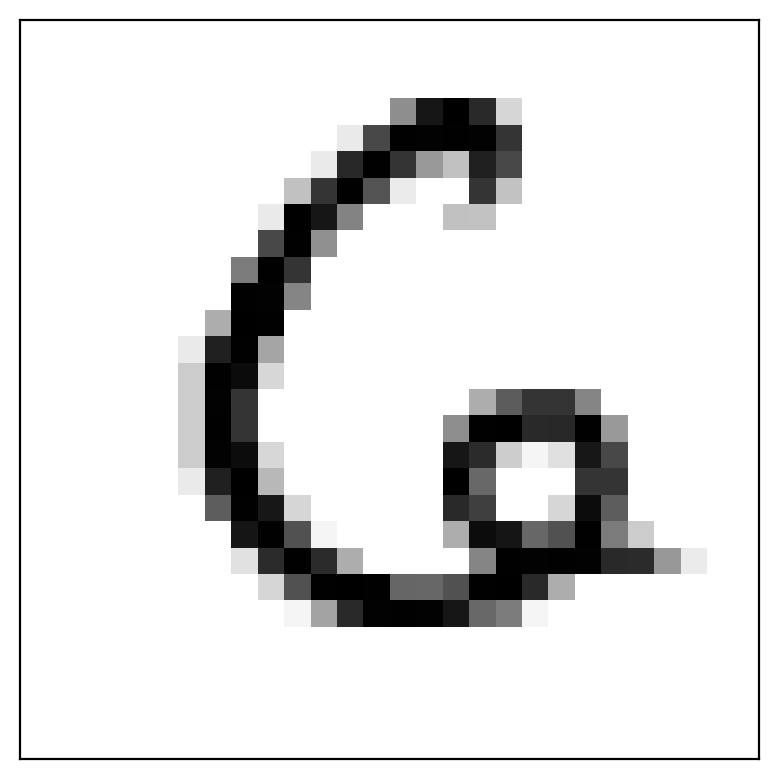

In [5]:
def display_image(im):
    plt.imshow(im, cmap='gray_r')
    plt.xticks([])
    plt.yticks([])
    
display_image(X_train[910])

# Softmax model

Reminder:
$$
\hat{y}_i = \text{softmax}(W x_i)
$$

A Keras model can be built by defining the model layers, then giving them to the `Sequential` model object.
You could also first create the model object and the use its `add` method to add layers.

- The first layer is an `Input` object.
- The `Flatten` layer just flatten the input data - turns it into a 1D array.
- The `Dense` layer uses matrix muliplication. We need to provide it with the number of outputs, in this case the number of categories, and the activation function, in this case the softmax function.

In [8]:
layers = [
    keras.Input((width, height)),
    keras.layers.Flatten(),
    keras.layers.Dense(ncats, activation='softmax', use_bias=False)
]
model = keras.models.Sequential(layers)
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_2 (Flatten)             │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │         7,840 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,840 (30.62 KB)

 Trainable params: 7,840 (30.62 KB)

 Non-trainable params: 0 (0.00 B)

Next, we need to compile the Keras model, configuring it for training.

In [9]:
model.compile(
    loss='categorical_crossentropy',
    optimizer='sgd',
    metrics=['accuracy']
)

Finally, we can train or fit the model. 

In [10]:
history = model.fit(
    X_train, Y_train,
    batch_size=50,
    epochs=30,
    validation_data=(X_test, Y_test)
).history

Epoch 1/30
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.6612 - loss: 1.3078 - val_accuracy: 0.8666 - val_loss: 0.5590
Epoch 2/30
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 1s 701us/step - accuracy: 0.8632 - loss: 0.5479 - val_accuracy: 0.8849 - val_loss: 0.4503
Epoch 3/30
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 1s 722us/step - accuracy: 0.8777 - loss: 0.4619 - val_accuracy: 0.8936 - val_loss: 0.4073
Epoch 4/30
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 1s 747us/step - accuracy: 0.8834 - loss: 0.4298 - val_accuracy: 0.8992 - val_loss: 0.3823
Epoch 5/30
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 1s 714us/step - accuracy: 0.8904 - loss: 0.3977 - val_accuracy: 0.9009 - val_loss: 0.3658
Epoch 6/30
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 1s 712us/step - accuracy: 0.8934 - loss: 0.3869 - val_accuracy: 0.9034 - val_loss: 0.3552
Epoch 7/30
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 1s 706us/step - accuracy: 0.8974 - loss: 0.3692 - val_accuracy: 0.9046 - val_loss: 0.3448
Epoch 8/30
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 1s 711us/step - accuracy: 0.9012 - l

Save the model and the training history:

In [11]:
model.save('../data/keras_ffn_model.keras')
with open("../data/keras_ffn_history.p", "wb") as f:
    pickle.dump(history, f)

Load the model and the history:

In [12]:
model = keras.models.load_model('../data/keras_ffn_model.keras')
with open("../data/keras_ffn_history.p", "rb") as f:
    history = pickle.load(f)

Next, plot the training history.

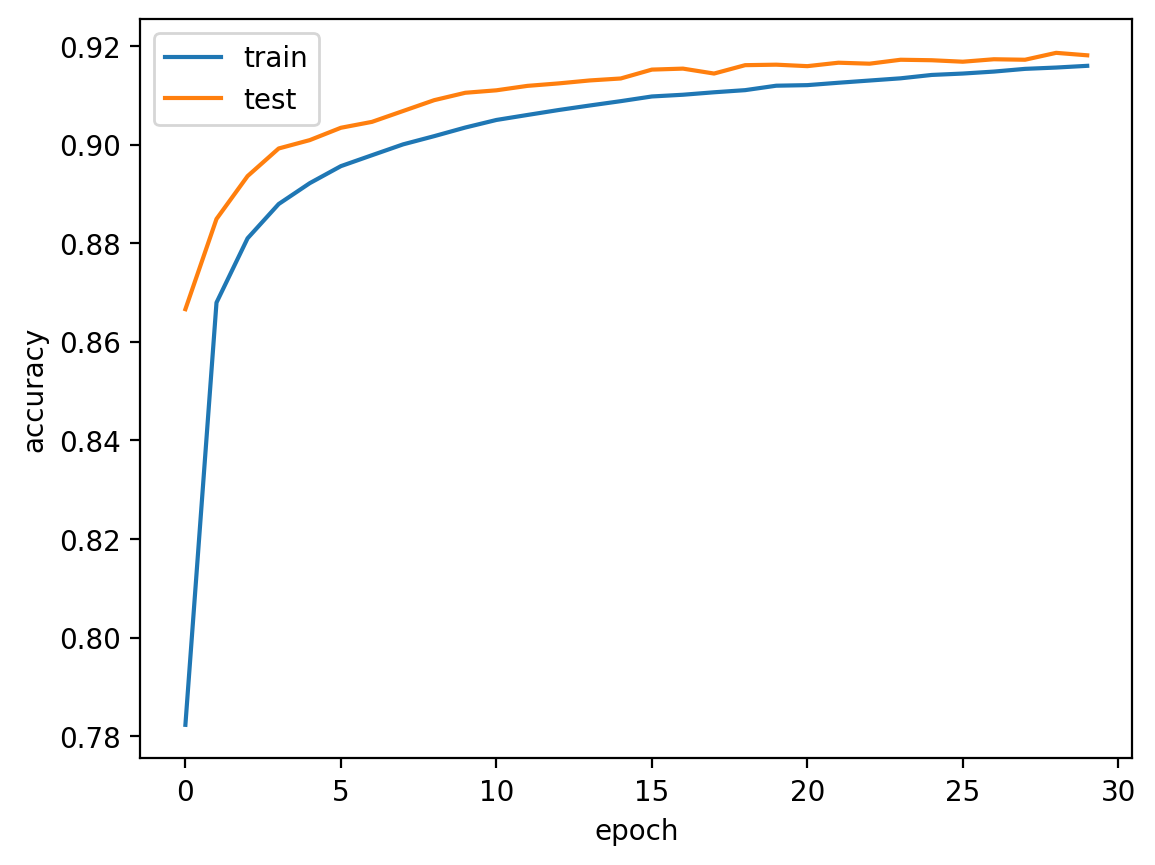

In [18]:
def plot_history(history):
    plt.plot(history['accuracy'], label='train')
    plt.plot(history['val_accuracy'], label='test')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend()

plot_history(history)

We can also use the model to make predictions:

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Truth: 7, Prediction: 7 (0.9952)


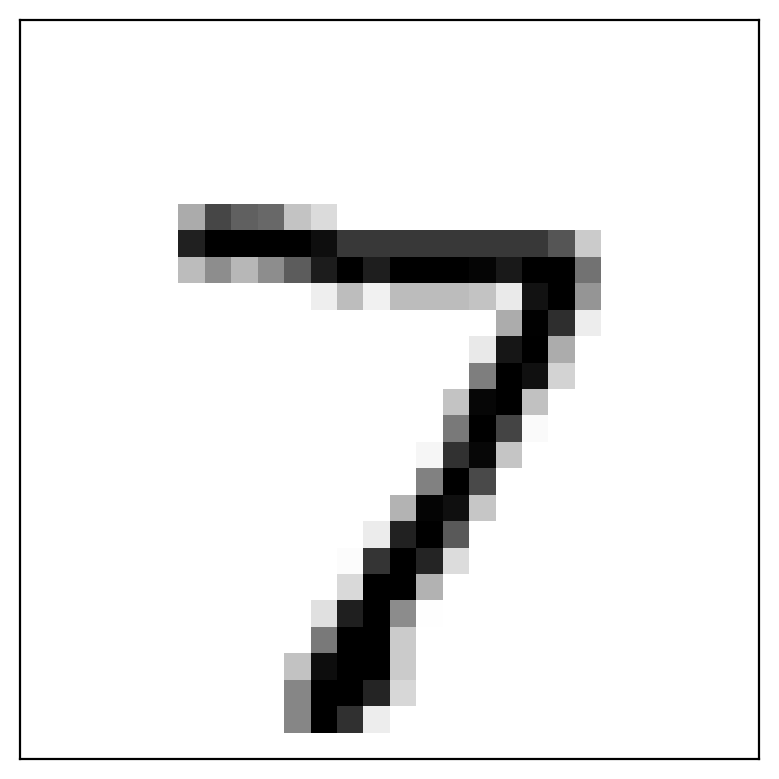

In [20]:
idx = 0
im = X_test[[idx]] # shape (1, 28, 28)
display_image(im[0])
yhat = model.predict(im)
print(
    "Truth: {}, Prediction: {} ({:.4f})".format(
        Y_test[idx].argmax(), yhat.argmax(), yhat.max()
))

# Exercise: Feed forward with one hidden layer

Let's add a hidden layer so that we have:
$$
x^{(2)}_i = \text{ReLU}(W^{(1)} x^{(1)}_i) $$$$
\hat{y}_i = \text{softmax}(W^{(2)} x^{(2)}_i) 
$$
Create a new model, with an additional hidden layer, compile it, and fit it.
Use the **Adam optimizer** instead of Stochastic Gradient Descent.

Then save the history and the model to `../data/keras_ffn2_history.p` and `../data/keras_ffn2_model.keras`.

A solution is [available](../solutions/K_FFN.ipynb).

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_3 (Flatten)             │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 100)            │        78,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 10)             │         1,000 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 79,400 (310.16 KB)

 Trainable params: 79,400 (310.16 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7856 - loss: 0.6973 - val_accuracy: 0.9432 - val_loss: 0.1961
Epoch 2/30
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9198 - loss: 0.2721 - val_accuracy: 0.9576 - val_loss: 0.1469
Epoch 3/30
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9329 - loss: 0.2252 - val_accuracy: 0.9623 - val_loss: 0.1254
Epoch 4/30
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9411 - loss: 0.1961 - val_accuracy: 0.9657 - val_loss: 0.1130
Epoch 5/30
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9450 - loss: 0.1815 - val_accuracy: 0.9692 - val_loss: 0.1038
Epoch 6/30
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9501 - loss: 0.1676 - val_accuracy: 0.9710 - val_loss: 0.0986
Epoch 7/30
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9517 - loss: 0.1641 - val_accuracy: 0.9705 - val_loss: 0.0949
Epoch 8/30
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9528 - loss: 0.1524 - 

In [27]:
model = keras.models.load_model('../data/keras_ffn2_model.keras')
with open("../data/keras_ffn2_history.p", "rb") as f:
    history = pickle.load(f)

Final test accuracy 0.9751


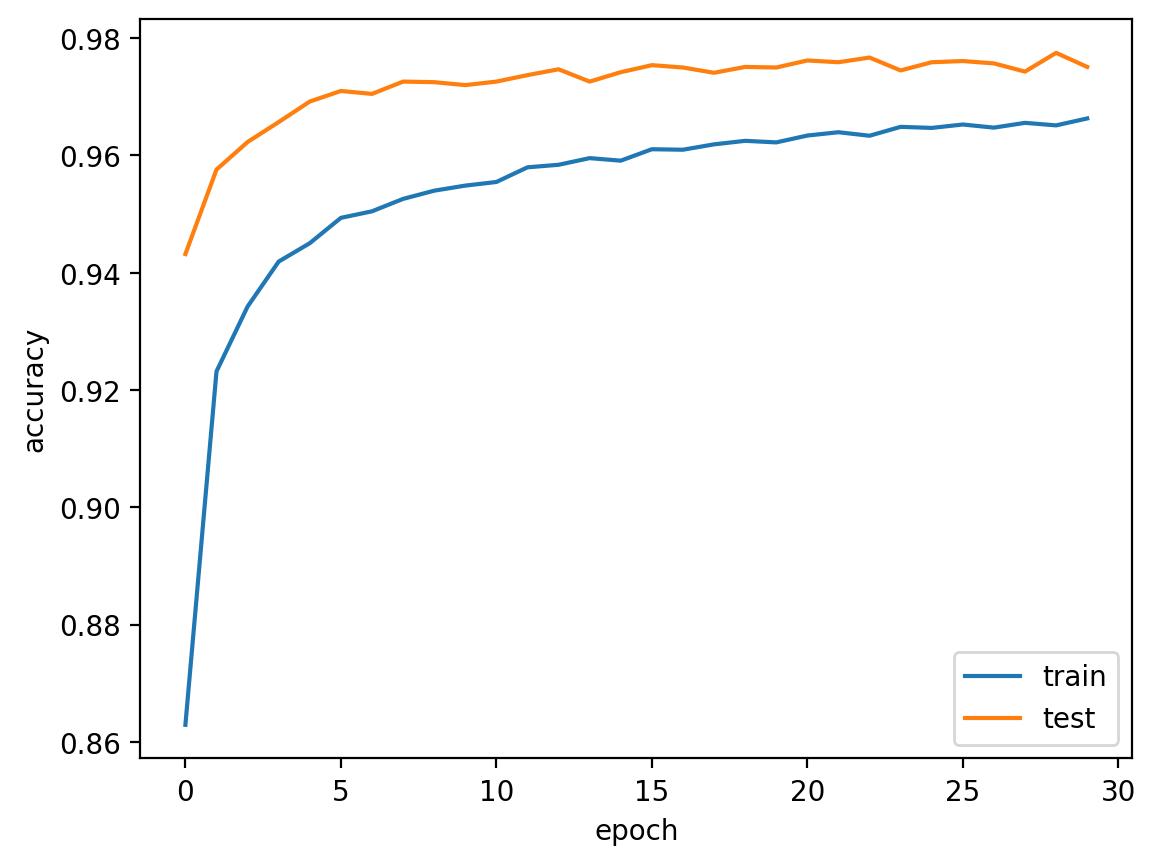

In [28]:
plot_history(history)
print("Final test accuracy {:.4f}".format(history['val_accuracy'][-1]))

# References

- Keras [docs](https://keras.io)
- See the [Keras examples library](https://github.com/keras-team/keras/tree/master/examples)

# Colophon
This notebook was written by [Yoav Ram](http://python.yoavram.com).

This work is licensed under a CC BY-NC-SA 4.0 International License.

![Python logo](https://www.python.org/static/community_logos/python-logo.png)